
0: 640x480 20 persons, 126.8ms
Speed: 4.6ms preprocess, 126.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)
Person at pixel (1287.8,1627.4) -> 3D: [    -1.2772     -1.7461     -2.5391], distance: 3.295 m
Person at pixel (769.6,1255.3) -> 3D: [   -0.93561      -1.737     -4.1072], distance: 4.505 m
Person at pixel (606.2,1252.2) -> 3D: [ -0.0023227     -1.7336     -4.2675], distance: 4.549 m
Person at pixel (1056.8,1434.9) -> 3D: [    -1.2772     -1.7461     -2.5391], distance: 3.295 m
Person at pixel (863.1,1176.7) -> 3D: [    -1.9835     -1.7185     -5.4283], distance: 5.981 m
Person at pixel (131.0,1318.6) -> 3D: [     1.9588     -1.8279      -3.952], distance: 4.715 m
Person at pixel (1173.1,1439.4) -> 3D: [    -1.2772     -1.7461     -2.5391], distance: 3.295 m
Person at pixel (187.5,1156.5) -> 3D: [     2.2378     -1.1752     -4.5148], distance: 5.113 m
Person at pixel (564.1,1129.9) -> 3D: [    0.40358     -1.7334     -7.2394], distance: 7.396 m
Person at pi

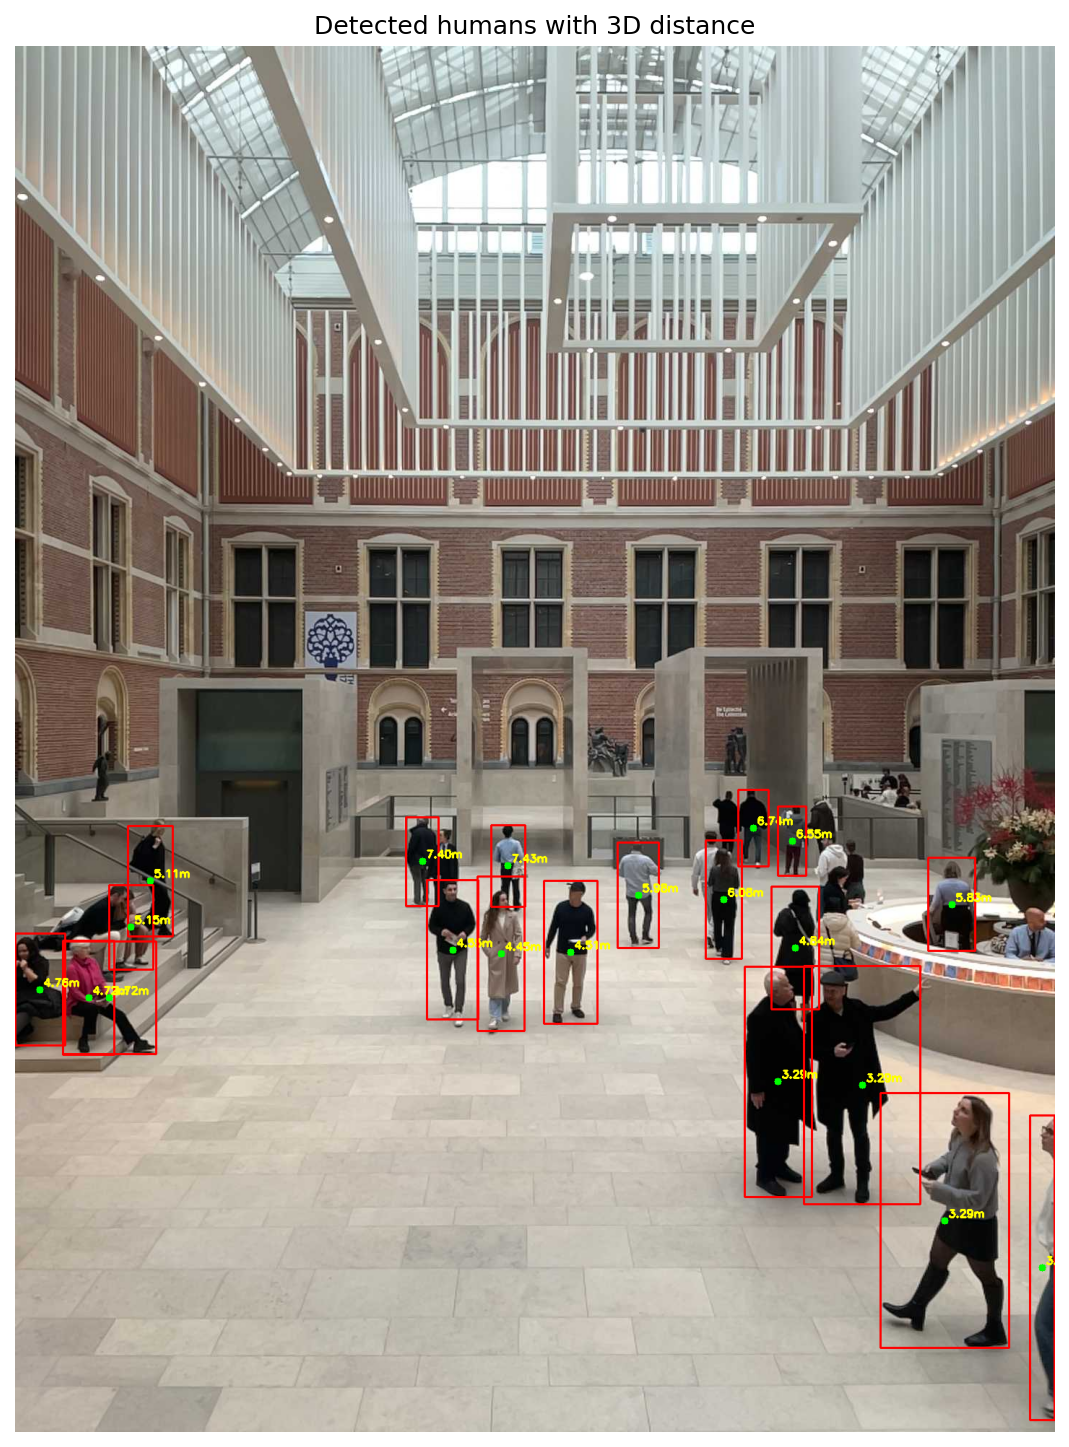

In [27]:
# -------------------------------
# Step 1: Imports
# -------------------------------
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
from PIL import Image
import json

# -------------------------------
# Step 2: Load PLY points + camera
# -------------------------------
points = np.load("src/points.npy")
colors = np.load("src/colors.npy")

with open("src/metadata.json") as f:
    pose = json.load(f)["poses"][0]

qx, qy, qz, qw = pose[:4]
tx, ty, tz = pose[4:7]
R_wc = R.from_quat([qx, qy, qz, qw]).as_matrix()
t_wc = np.array([tx, ty, tz])

# Load image
image_path = "src/rgb/0.jpg"
img_cv = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
height, width = img_rgb.shape[:2]

# Approximate intrinsics
fx = fy = 0.5 * width
cx, cy = width / 2, height / 2

# -------------------------------
# Step 3: Projection helpers
# -------------------------------
def project_points_to_image(points):
    Pc = (R_wc.T @ (points.T - t_wc[:, None])).T
    Xc, Yc, Zc = Pc[:,0], Pc[:,1], Pc[:,2]
    u = fx * (Xc / Zc) + cx
    v = fy * (Yc / Zc) + cy
    return np.stack([u, v], axis=1), Zc

def pixel_to_3d(u, v):
    uv, Zc = project_points_to_image(points)
    dist2 = (uv[:,0] - u)**2 + (uv[:,1] - v)**2
    idx = np.argmin(dist2)
    point_world = points[idx]
    Pc = (R_wc.T @ (point_world - t_wc))
    distance = np.linalg.norm(Pc)
    return point_world, distance

# -------------------------------
# Step 4: YOLO human detection
# -------------------------------
model = YOLO("yolov8n.pt")  # nano model
results = model.predict(img_rgb, conf=0.3, classes=[0])  # 0=person

# -------------------------------
# Step 5: Process detections
# -------------------------------
annotated_img = img_rgb.copy()

for det in results[0].boxes:
    x1, y1, x2, y2 = det.xyxy[0].cpu().numpy()  # bounding box
    u_mid, v_mid = (x1 + x2)/2, (y1 + y2)/2

    # Map midpoint pixel to 3D
    point_3d, dist = pixel_to_3d(u_mid, v_mid)

    # Draw bounding box
    cv2.rectangle(annotated_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)
    # Draw midpoint
    cv2.circle(annotated_img, (int(u_mid), int(v_mid)), 5, (0,255,0), -1)
    # Put distance text
    cv2.putText(annotated_img, f"{dist:.2f}m", (int(u_mid)+5,int(v_mid)-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 2)

    print(f"Person at pixel ({u_mid:.1f},{v_mid:.1f}) -> 3D: {point_3d}, distance: {dist:.3f} m")

# -------------------------------
# Step 6: Show annotated image (high-res)
# -------------------------------
plt.figure(figsize=(18,12), dpi=150)  # bigger figure and higher resolution
plt.imshow(annotated_img)
plt.axis('off')
plt.title("Detected humans with 3D distance")
plt.show()
